In [1]:
import pennylane as qml
import torch
from torch import nn
from torch.utils.data import DataLoader
from pennylane import numpy as np
import matplotlib.pyplot as plt
#from tqdm import tqdm
import pennylane as pl
from sklearn.datasets import fetch_california_housing
import torch
from sklearn.metrics import r2_score

#device = 'cpu' # Cuda support for PennyLane is possible though

In [2]:
import sys
sys.path.insert(0, "../")
import utils.utils as utils
import models.fourier_models as fm
import models.quantum_models as qm
from sklearn.model_selection import train_test_split # forgotten by the author

# Evaluation of the model
In the following we will through one run evaluate the results of the model given the different values of rescaling:
- Rescaling [-pi/2, pi/2]
    -  mode = half
    -  mode = positive
    -  mode = all
The evaluation metrics are MARE, R sqaured.

This notebook is different from NN_California_pi_over_2 as we have changed the evaluation function to compute the metrics mentionned here above.

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch

# Assuming fetch_california_housing is already defined and imported
data = fetch_california_housing()
X = torch.from_numpy(data.data).float()
y = torch.from_numpy(data.target).float()

# Split the dataset into training + validation and testing (hold-out set)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2)

# Further split the training + validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=2)  # 25% of X_train_val will be X_val

# Now we scale the data, ensuring no data leakage happens

# Calculate scaling parameters (min and max in this case) only from the training set
min_value, max_value = X_train.min(dim=0)[0], X_train.max(dim=0)[0]

# Scale the training data
X_train_scaled = utils.data_scaler(X_train, min_value=min_value, max_value=max_value, interval=(-torch.pi/2, torch.pi/2))

# Apply the same scaling to the validation and test data
X_val_scaled = utils.data_scaler(X_val, min_value=min_value, max_value=max_value, interval=(-torch.pi/2, torch.pi/2))
X_test_scaled = utils.data_scaler(X_test, min_value=min_value, max_value=max_value, interval=(-torch.pi/2, torch.pi/2))


# Create TensorDatasets and DataLoaders with the scaled data
train_dataset = TensorDataset(X_train_scaled, y_train)
val_dataset = TensorDataset(X_val_scaled, y_val)
test_dataset = TensorDataset(X_test_scaled, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=500)
test_dataloader = DataLoader(test_dataset, batch_size=500)

In [4]:
# Define training function
def train(dataloader, model, loss_fn, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    num_batches = len(dataloader)

    for X, y in dataloader:
        # Define the closure function
        def closure():
            optimizer.zero_grad()
            output = model(X)
            loss = loss_fn(output.squeeze(), y)  # Compute loss
            loss.backward()  # Perform backpropagation
            return loss

        loss = closure()  # Compute the loss and perform backpropagation
        optimizer.step(closure)  # Update model parameters using the optimizer

        total_loss += loss.item()  # Accumulate the loss

    average_loss_per_batch = total_loss / num_batches  # Calculate the average loss
    return average_loss_per_batch


# Define evaluation function for both validation and test sets
def evaluate(dataloader, model, loss_fn):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_absolute_relative_error = 0
    predictions, targets = [], []
    num_batches = len(dataloader)

    with torch.no_grad():
        for X, y in dataloader:
            output = model(X).squeeze()  # Squeeze the output here as well
            loss = loss_fn(output, y)
            total_loss += loss.item()
            total_absolute_relative_error += torch.abs((y - output) / torch.clamp(y, min=1e-6)).sum().item()
            predictions.extend(output.tolist())
            targets.extend(y.tolist())

    # Calculate average loss and error metrics per batch
    average_loss = total_loss / num_batches
    avg_mare = total_absolute_relative_error / len(dataloader.dataset)  # MARE over the entire dataset
    r2 = r2_score(targets, predictions)  # R² score

    return average_loss, avg_mare, r2



#### 3-a W is generated with Mode = "half"


Epoch 1
-------------------------------
Train Loss: 0.6911
Validation Loss: 0.4525, MARE: 0.2821, R-squared: 0.6542
Epoch 2
-------------------------------
Train Loss: 0.4582
Validation Loss: 0.4578, MARE: 0.2796, R-squared: 0.6459
Epoch 3
-------------------------------
Train Loss: 0.4667
Validation Loss: 0.4844, MARE: 0.3044, R-squared: 0.6273
Epoch 4
-------------------------------
Train Loss: 0.4334
Validation Loss: 0.4279, MARE: 0.2811, R-squared: 0.6715
Epoch 5
-------------------------------
Train Loss: 0.4343
Validation Loss: 0.4588, MARE: 0.2799, R-squared: 0.6519
Epoch 6
-------------------------------
Train Loss: 0.4237
Validation Loss: 0.4944, MARE: 0.3091, R-squared: 0.6251
Epoch 7
-------------------------------
Train Loss: 0.4390
Validation Loss: 0.4140, MARE: 0.2547, R-squared: 0.6813
Epoch 8
-------------------------------
Train Loss: 0.4179
Validation Loss: 0.4244, MARE: 0.2623, R-squared: 0.6751
Epoch 9
-------------------------------
Train Loss: 0.4208
Validation Lo

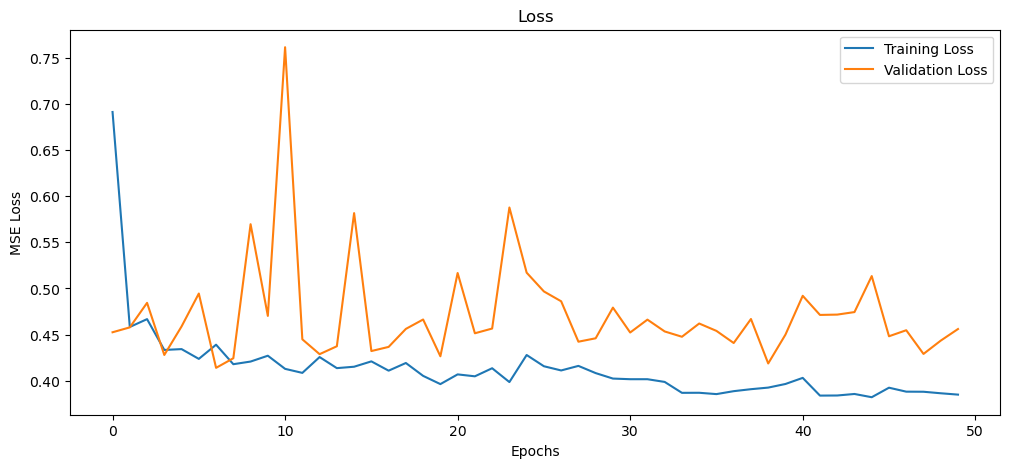

Test Loss: 0.6126, Test MARE: 0.2883, Test R-squared: 0.5336


In [5]:
# Define maximum frequency and dimension
max_freq = 2
dim = X_train.shape[1]  # Assuming X_scaled is a 2D tensor [n_samples, n_features]
W = utils.freq_generator(max_freq, dim, mode="half").float()

# Initialize the model
model = fm.Fourier_model(W).float()

# Define the loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Initialize the optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

# Prepare lists to store loss and evaluation metrics
NN_loss = []
NN_val_loss = []
NN_val_mare = []
NN_val_r_squared = []

# Training loop
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_mare, val_r_squared = evaluate(val_dataloader, model, loss_fn)  # Unpack the additional metrics

    NN_loss.append(train_loss)
    NN_val_loss.append(val_loss)
    NN_val_mare.append(val_mare)
    NN_val_r_squared.append(val_r_squared)

    # Print out the metrics for the current epoch
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, MARE: {val_mare:.4f}, R-squared: {val_r_squared:.4f}")

# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.plot(x, NN_loss, label="Training Loss")
plt.plot(x, NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_mare, test_r_squared = evaluate(test_dataloader, model, loss_fn)  # Unpack the additional metrics
print(f"Test Loss: {test_loss:.4f}, Test MARE: {test_mare:.4f}, Test R-squared: {test_r_squared:.4f}")


#### 3-b W is generated with Mode = "positive"


Epoch 1
-------------------------------
Train Loss: 0.7649
Validation Loss: 0.4406, MARE: 0.2647, R-squared: 0.6612
Epoch 2
-------------------------------
Train Loss: 0.4760
Validation Loss: 0.4751, MARE: 0.2983, R-squared: 0.6360
Epoch 3
-------------------------------
Train Loss: 0.4564
Validation Loss: 0.5133, MARE: 0.3099, R-squared: 0.6049
Epoch 4
-------------------------------
Train Loss: 0.4788
Validation Loss: 0.4408, MARE: 0.2932, R-squared: 0.6614
Epoch 5
-------------------------------
Train Loss: 0.4446
Validation Loss: 0.4440, MARE: 0.2754, R-squared: 0.6557
Epoch 6
-------------------------------
Train Loss: 0.4365
Validation Loss: 0.5042, MARE: 0.2993, R-squared: 0.6109
Epoch 7
-------------------------------
Train Loss: 0.4435
Validation Loss: 0.4284, MARE: 0.2742, R-squared: 0.6703
Epoch 8
-------------------------------
Train Loss: 0.4291
Validation Loss: 0.4249, MARE: 0.2743, R-squared: 0.6760
Epoch 9
-------------------------------
Train Loss: 0.4362
Validation Lo

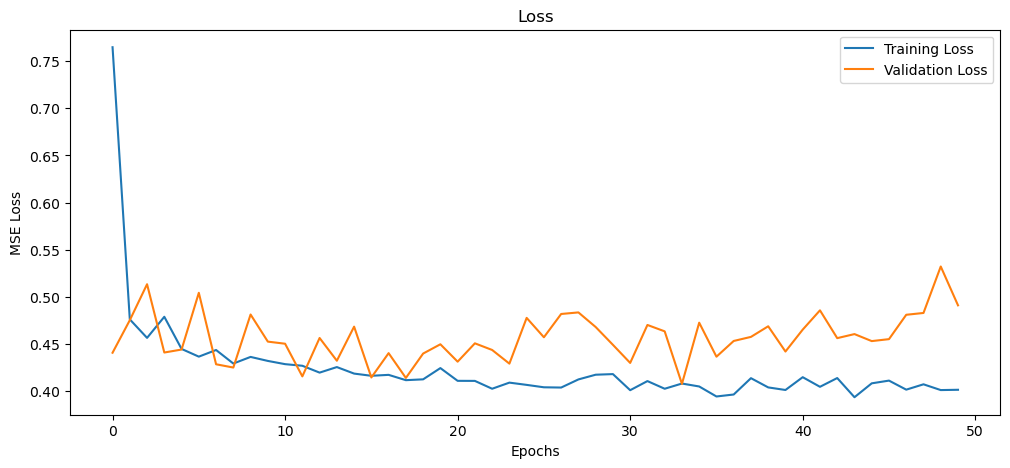

Test Loss: 0.7681, Test MARE: 0.2755, Test R-squared: 0.4065


In [6]:
# Define maximum frequency and dimension
max_freq = 2
dim = X_train.shape[1]  # Assuming X_scaled is a 2D tensor [n_samples, n_features]
W = utils.freq_generator(max_freq, dim, mode="positive").float()

# Initialize the model
model = fm.Fourier_model(W).float()

# Define the loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Initialize the optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

# Prepare lists to store loss and evaluation metrics
NN_loss = []
NN_val_loss = []
NN_val_mare = []
NN_val_r_squared = []

# Training loop
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_mare, val_r_squared = evaluate(val_dataloader, model, loss_fn)  # Unpack the additional metrics

    NN_loss.append(train_loss)
    NN_val_loss.append(val_loss)
    NN_val_mare.append(val_mare)
    NN_val_r_squared.append(val_r_squared)

    # Print out the metrics for the current epoch
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, MARE: {val_mare:.4f}, R-squared: {val_r_squared:.4f}")

# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.plot(x, NN_loss, label="Training Loss")
plt.plot(x, NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_mare, test_r_squared = evaluate(test_dataloader, model, loss_fn)  # Unpack the additional metrics
print(f"Test Loss: {test_loss:.4f}, Test MARE: {test_mare:.4f}, Test R-squared: {test_r_squared:.4f}")


#### 3-c W is generated with Mode = "all"


Epoch 1
-------------------------------
Train Loss: 0.7610
Validation Loss: 0.4577, MARE: 0.3002, R-squared: 0.6458
Epoch 2
-------------------------------
Train Loss: 0.4641
Validation Loss: 0.5205, MARE: 0.2935, R-squared: 0.6020
Epoch 3
-------------------------------
Train Loss: 0.4522
Validation Loss: 0.4422, MARE: 0.2828, R-squared: 0.6660
Epoch 4
-------------------------------
Train Loss: 0.4479
Validation Loss: 0.4692, MARE: 0.2955, R-squared: 0.6411
Epoch 5
-------------------------------
Train Loss: 0.4363
Validation Loss: 0.4134, MARE: 0.2714, R-squared: 0.6837
Epoch 6
-------------------------------
Train Loss: 0.4423
Validation Loss: 0.4418, MARE: 0.2657, R-squared: 0.6625
Epoch 7
-------------------------------
Train Loss: 0.4383
Validation Loss: 0.4474, MARE: 0.2968, R-squared: 0.6594
Epoch 8
-------------------------------
Train Loss: 0.4319
Validation Loss: 0.4879, MARE: 0.2972, R-squared: 0.6333
Epoch 9
-------------------------------
Train Loss: 0.4296
Validation Lo

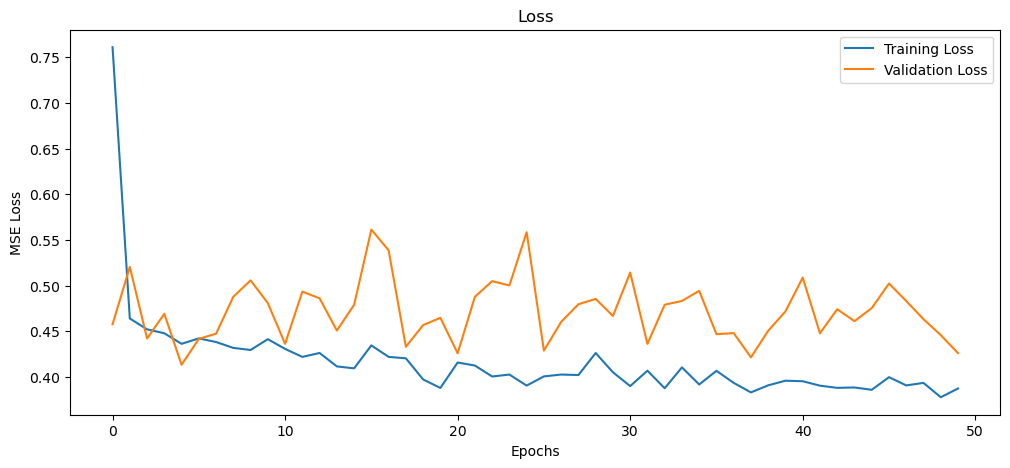

Test Loss: 0.5520, Test MARE: 0.2551, Test R-squared: 0.5774


In [7]:
# Define maximum frequency and dimension
max_freq = 2
dim = X_train.shape[1]  # Assuming X_scaled is a 2D tensor [n_samples, n_features]
W = utils.freq_generator(max_freq, dim, mode="all").float()

# Initialize the model
model = fm.Fourier_model(W).float()

# Define the loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Initialize the optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

# Prepare lists to store loss and evaluation metrics
NN_loss = []
NN_val_loss = []
NN_val_mare = []
NN_val_r_squared = []

# Training loop
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_mare, val_r_squared = evaluate(val_dataloader, model, loss_fn)  # Unpack the additional metrics

    NN_loss.append(train_loss)
    NN_val_loss.append(val_loss)
    NN_val_mare.append(val_mare)
    NN_val_r_squared.append(val_r_squared)

    # Print out the metrics for the current epoch
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, MARE: {val_mare:.4f}, R-squared: {val_r_squared:.4f}")

# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.plot(x, NN_loss, label="Training Loss")
plt.plot(x, NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_mare, test_r_squared = evaluate(test_dataloader, model, loss_fn)  # Unpack the additional metrics
print(f"Test Loss: {test_loss:.4f}, Test MARE: {test_mare:.4f}, Test R-squared: {test_r_squared:.4f}")


Based on the training and validation results over 50 epochs, here are some key observations:

- **Training Loss**:
  - **Trend**: There's a general downward trend in training loss, from 0.7610 to 0.3874, indicating consistent learning and improvement in the model's ability to fit the training data.
  - **Implications**: The decreasing training loss suggests that the model is effectively learning the underlying patterns in the training dataset.

- **Validation Loss**:
  - **Trend**: Validation loss fluctuates across epochs, with some epochs showing higher loss than others. The lowest observed is 0.4262, while the highest is around 0.5614.
  - **Implications**: The fluctuation in validation loss suggests variability in how well the model generalizes to unseen data. The model might be experiencing some overfitting, as indicated by lower training loss and higher validation loss in several epochs.

- **Mean Absolute Relative Error (MARE)**:
  - **Trend**: MARE also fluctuates, with the lowest being 0.2557 and the highest around 0.3133.
  - **Implications**: The fluctuation in MARE indicates inconsistency in the model's prediction accuracy relative to the actual values. A lower MARE is desirable as it indicates smaller relative errors.

- **R-squared (R²) Score**:
  - **Trend**: R² scores range from 0.5336 to 0.6751, indicating moderate to good model performance in different epochs.
  - **Implications**: The variation in R² scores suggests that the model's ability to explain the variance in the validation data is inconsistent. Higher R² scores in some epochs are a positive sign, but the inconsistency needs to be addressed.

- **Test Results**:
  - **Test Loss**: Higher than the average validation loss, which might suggest a gap in generalization to completely unseen data.
  - **Test MARE and R-squared**: Similar trends to validation metrics, reinforcing the need for potential improvements in model robustness and consistency.

In summary, the model shows a decent learning capacity but exhibits signs of overfitting and inconsistency in generalization. Steps to consider include experimenting with model architecture, regularization techniques, or varying the training data. Monitoring these metrics as training continues will provide deeper insights and guide further optimization.